In [1]:
%load_ext autoreload
%autoreload 2
#%load_ext profila
from electron_scattering import Environment, propagate_photons
import numba
numba.set_num_threads(8)
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c

In [3]:
central_wavelength = 5000 * u.AA
freq_fact = (central_wavelength.to(u.J, equivalencies=u.spectral())/c.c**2/c.m_e).si
env_obj = Environment(freq_fact=freq_fact, tau=0.01)
energies, interactions = propagate_photons(n_pkts=int(1e7), env_obj=env_obj)
wavelengths = (energies * c.m_e * c.c**2).to(u.AA, equivalencies=u.spectral())
frequencies = (energies * c.m_e * c.c**2).to(u.Hz, equivalencies=u.spectral())

In [ ]:
wl_edges = np.linspace(np.min(wavelengths), np.max(wavelengths), 1000)
counts, _, _ = plt.hist(wavelengths, bins=wl_edges, histtype='step');
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Counts')
plt.yscale('log')

### Test for small tau: 
Correct number of non-scatterings

In [4]:
env_obj = Environment(freq_fact=freq_fact, tau=0.01, R_inner=0.01)
energies, interactions = propagate_photons(n_pkts=int(1e6), env_obj=env_obj)
expected = (1-np.exp(-0.01)) * 1e7
actual = np.sum(interactions > 0)
print(f"Expected: {expected:.2e} +- {np.sqrt(expected):.2e}, Actual: {actual:.2e}, Diff: {actual-expected:.2}")

Expected: 9.95e+04 +- 3.15e+02, Actual: 1.00e+04, Diff: -8.9e+04


In [5]:
env_obj = Environment(freq_fact=freq_fact, tau=0.01, R_inner=1)
energies, interactions = propagate_photons(n_pkts=int(1e6), env_obj=env_obj)
expected = (1-np.exp(-0.01)) * 1e7
actual = np.sum(interactions > 0)
print(f"Expected: {expected:.2e} +- {np.sqrt(expected):.2e}, Actual: {actual:.2e}, Diff: {actual-expected:.2}")

Expected: 9.95e+04 +- 3.15e+02, Actual: 1.01e+04, Diff: -8.9e+04


### Test for intermediate tau=3
Test that it gives the same result as old code:

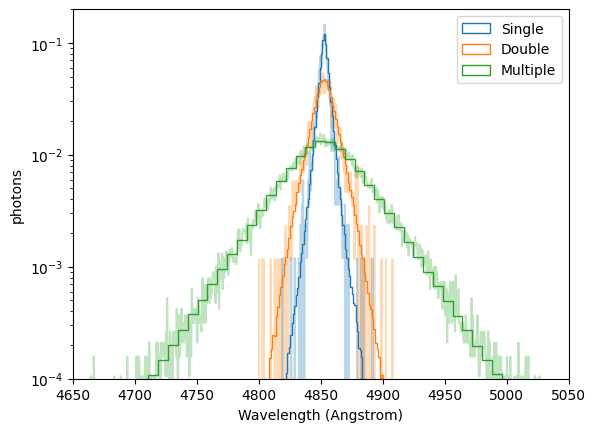

In [136]:
def plot_old(freq_fact = 5.e-6, filename='spectrum.dat'):
    freqs, spectrum, spectrum_single, spectrum_double, spectrum_more = np.loadtxt(filename, unpack=True)
    # try plotting it
    x_vals = (freqs * c.m_e * c.c**2).to(u.AA, equivalencies=u.spectral()).value
    #plt.ylim([0,20])
    plt.plot(x_vals,spectrum_single / np.trapz(spectrum_single, -x_vals), alpha=0.3)
    plt.plot(x_vals, spectrum_double / np.trapz(spectrum_double, -x_vals), alpha=0.3)
    plt.plot(x_vals, spectrum_more / np.trapz(spectrum_more, -x_vals), alpha=0.3)
def plot_new(freq_fact = 5.e-6):
    env_obj = Environment(freq_fact=freq_fact, tau=3)
    energies, interactions = propagate_photons(n_pkts=int(1e7), env_obj=env_obj)
    wavelengths = (energies * c.m_e * c.c**2).to(u.AA, equivalencies=u.spectral())
    
    plt.hist(wavelengths[interactions== 1], bins=100, histtype='step', color='C0', label='Single', density=True)
    plt.hist(wavelengths[interactions== 2], bins=100, histtype='step', color='C1', label='Double', density=True)
    plt.hist(wavelengths[interactions > 2], bins=100, histtype='step', color='C2', label='Multiple', density=True)
    
plot_old()
plot_new()
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('photons')
plt.xlim([4650,5050])
plt.yscale('log')
plt.ylim([1e-4,0.2])
plt.legend()

### Physical importance of parameters:

Is inner radius important?

Running default
Running R_inner=1e-3
Running volumetric


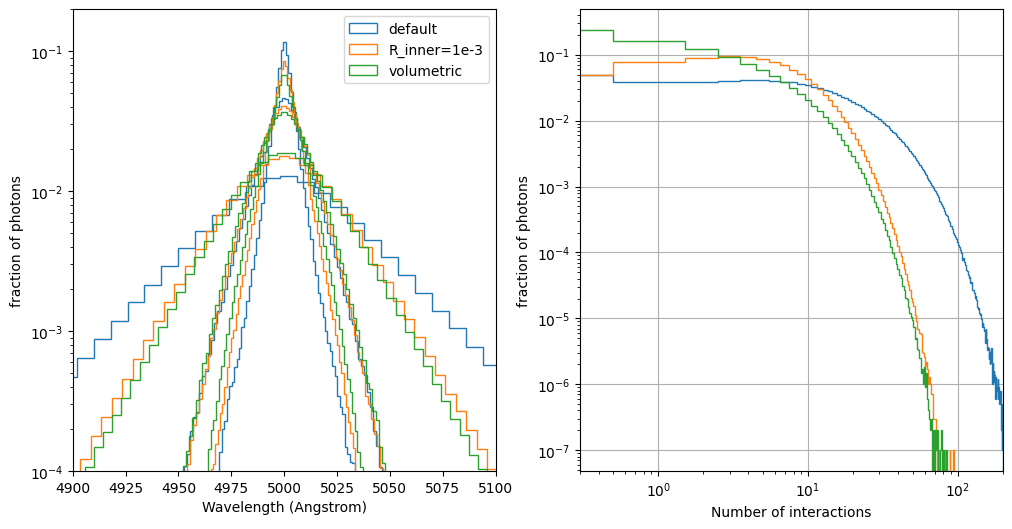

In [7]:
def plot_for_environment(env_obj, idx, label, axes):
    energies, interactions = propagate_photons(n_pkts=int(1e7), env_obj=env_obj)
    wavelengths = (energies * c.m_e * c.c**2).to(u.AA, equivalencies=u.spectral())
    axes[0].hist(wavelengths[interactions== 1], bins=100, histtype='step', color=f'C{idx}', density=True)
    axes[0].hist(wavelengths[interactions== 2], bins=100, histtype='step', color=f'C{idx}', density=True)
    axes[0].hist(wavelengths[interactions > 2], bins=100, histtype='step', color=f'C{idx}', label=label, density=True)
    
    axes[1].hist(interactions, bins=np.arange(-0.5, 200), histtype='step', color=f'C{idx}', density=True)


central_wavelength = 5000 * u.AA
freq_fact = (central_wavelength.to(u.J, equivalencies=u.spectral())/c.c**2/c.m_e).si

test_cases = [Environment(freq_fact=freq_fact, tau=3), 
              Environment(freq_fact=freq_fact, tau=3, R_inner=1e-5),
              Environment(freq_fact=freq_fact, tau=3, R_inner=1e-5, volume_init=True)]

names = ['default', 'R_inner=1e-3', 'volumetric']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for idx, (env_obj, name) in enumerate(zip(test_cases, names)):
    print("Running", name)
    plot_for_environment(env_obj, idx, name, axes)

axes[0].set_xlabel('Wavelength (Angstrom)')
axes[0].set_ylabel('fraction of photons')
axes[0].set_xlim(central_wavelength.value - 100, central_wavelength.value + 100)
axes[0].set_yscale('log')
axes[0].set_ylim(1e-4,0.2)
axes[0].legend()

axes[1].set_xlabel('Number of interactions')
axes[1].set_ylabel('fraction of photons')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlim(0.3, 200)
axes[1].grid()